<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch6_LU_vs_Cholesky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LU factorizations
- Pivoting (do we have to?)
- Speed compared to Cholesky
- Speed of pivoting, and GPU implementation

# LU vs Cholesky factorization

If a matrix $A$ is positive definite, then we can do an LU factorization, but we should do Cholesky since it's a bit faster (about 1.7x faster).

Overall, finding the Cholesky factorization of a positive definite matrix is faster than finding the LU factorization of a general matrix

Cholesky decompositions do not need to pivot. The relative speed gains over LU factorization should probably be larger on a computer with many cores (colab just has 2 cores, so we don't see too much effect)

In [2]:
import numpy as np
import scipy.linalg as sla
import time
import matplotlib.pyplot as plt

## Why pivot?
In Matrix Methods (APPM 3310), we pivoted during Gaussian Elimination (or LU) when we had a 0 in the pivot location, so we **had to** pivot.

For stability reasons, if we have something **almost zero** then we don't have to pivot, but it's **a good idea**

In [51]:
A = np.array( [[1e-14,np.pi],[1,np.pi]])
# A = np.array( [[2,np.pi],[1,np.pi]]) # First, do it with this *nice* matrix
print('condition number is', np.linalg.cond(A)) # It's *not* ill-conditioned, so we don't have to lose digits...
with np.printoptions(precision=3, suppress=False):
    print(A)
x = np.ones(2)
b = A@x

# Let's do Gaussian elimination by hand
print('Now do Gaussian elimination')
scale = A[1,0]/A[0,0]
A[1] -= A[0] * scale
b[1] -= b[0] * scale
with np.printoptions(precision=3, suppress=False):
    print(A)

condition number is 6.446369108720346
[[1.000e-14 3.142e+00]
 [1.000e+00 3.142e+00]]
Now do Gaussian elimination
[[ 1.000e-14  3.142e+00]
 [ 0.000e+00 -3.142e+14]]


And do back-substitution

In [52]:
xhat = np.zeros(2) # our solution
xhat[1] = b[1]/A[1,1]
xhat[0] = (b[0] - A[0,1]*xhat[1])/A[0,0]
print(f'xhat[0] is {xhat[0]:.15f} (should be exactly 1)')
print(f'xhat[1] is {xhat[1]:.15f} (should be exactly 1)')

xhat[0] is 1.021405182655144 (should be exactly 1)
xhat[1] is 1.000000000000000 (should be exactly 1)


What happened? The $A_{2,2}$ entry had almost no effect after we did the row operation

In [42]:
print(f'{-A[1,1]/1e14:.15f}')
print(f'{np.pi:.15f}')

3.141592653589762
3.141592653589793


## Let's see how to use Scipy's LU factorization routines

In [3]:
n = 6
rng   = np.random.default_rng(123)
A = rng.standard_normal((int(n),int(n)))

LU,piv = sla.lu_factor(A,check_finite=False)
print('LU is')
with np.printoptions(precision=3, suppress=True):
    print(LU)
print('pivot array (weird format!) is')
print(piv)

LU is
[[ 1.192 -0.671  1.     0.136  1.532 -0.66 ]
 [-0.303 -1.434  1.53  -2.131  0.095 -0.036]
 [-0.262 -0.113 -1.773  0.622  1.953  0.95 ]
 [-0.83   0.645 -0.638  2.078  3.377  0.659]
 [-0.534 -0.128 -0.233 -0.182  1.996 -1.542]
 [ 0.633 -0.195 -0.534  0.436 -0.495 -0.127]]
pivot array (weird format!) is
[2 5 3 3 5 5]


From the documentation of LAPACK's `dgetrf`:

PIV is INTEGER array, dimension (min(M,N))
The pivot indices; for $1 \le i \le \min(M,N)$, row $i$ of the
matrix was interchanged with row IPIV($i$).

And call the other LU function, `lu`

In [5]:
P,L,U = sla.lu(A,check_finite=False)
with np.printoptions(precision=3, suppress=True):
    print('P^T is')
    print(P.T)
    print('L is')
    print(L)
    print('U is')
    print(U)

P^T is
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
L is
[[ 1.     0.     0.     0.     0.     0.   ]
 [-0.303  1.     0.     0.     0.     0.   ]
 [-0.262 -0.113  1.     0.     0.     0.   ]
 [-0.83   0.645 -0.638  1.     0.     0.   ]
 [-0.534 -0.128 -0.233 -0.182  1.     0.   ]
 [ 0.633 -0.195 -0.534  0.436 -0.495  1.   ]]
U is
[[ 1.192 -0.671  1.     0.136  1.532 -0.66 ]
 [ 0.    -1.434  1.53  -2.131  0.095 -0.036]
 [ 0.     0.    -1.773  0.622  1.953  0.95 ]
 [ 0.     0.     0.     2.078  3.377  0.659]
 [ 0.     0.     0.     0.     1.996 -1.542]
 [ 0.     0.     0.     0.     0.    -0.127]]


## Now let's do some timing (CPU)

In [7]:
rng   = np.random.default_rng()
nList = np.logspace(2.5,3.6,12,dtype=int)
timeLU   = []
timeLU_v2   = []
timeChol = []

for n in nList:
  A = rng.standard_normal((int(n),int(n)))

  # both lu and lu_factor exist
  tStart = time.perf_counter()
  LU,pivots = sla.lu_factor(A,check_finite=False)
  timeLU.append( time.perf_counter() - tStart )

  tStart = time.perf_counter()
  P,L,U = sla.lu(A,check_finite=False)
  timeLU_v2.append( time.perf_counter() - tStart )

  # make it positive semi-definite, and (with probability 1) positive definite
  A = A@A.T

  tStart = time.perf_counter()
  L = sla.cholesky(A,check_finite=False)
  timeChol.append( time.perf_counter() - tStart )


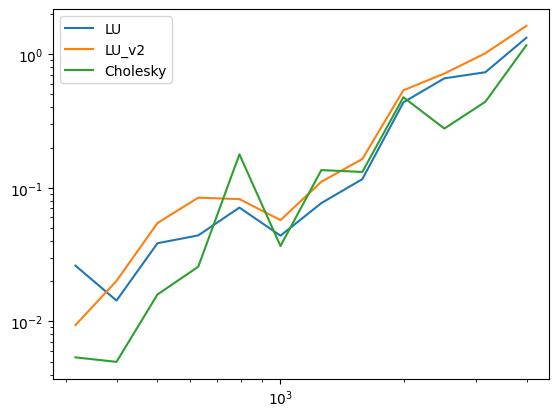

In [8]:
plt.loglog( nList, timeLU, label='LU')
plt.loglog( nList, timeLU_v2, label='LU_v2')
plt.loglog( nList, timeChol, label='Cholesky')
plt.legend()
plt.show()

On my 4-core laptop, not only are things faster, but there's more difference between the two different types of LU. My results are:

```
Time for Cholesky at largest size is 0.27839755200011496
Time for LU at largest size is 0.5116191430001891
Time for LU v2 at largest size is 0.8564363280001999
Ratio 1.8377285982743763
```



In [9]:
print("Time for Cholesky at largest size is", timeChol[-1] )
print("Time for LU at largest size is", timeLU[-1] )
print("Time for LU v2 at largest size is", timeLU_v2[-1] )
print("Ratio", timeLU[-1]/timeChol[-1] )

Time for Cholesky at largest size is 1.167427812000028
Time for LU at largest size is 1.328048908000028
Time for LU v2 at largest size is 1.6298564660000352
Ratio 1.1375854629716462


### Make a plot that normalizes by $O(n^3)$

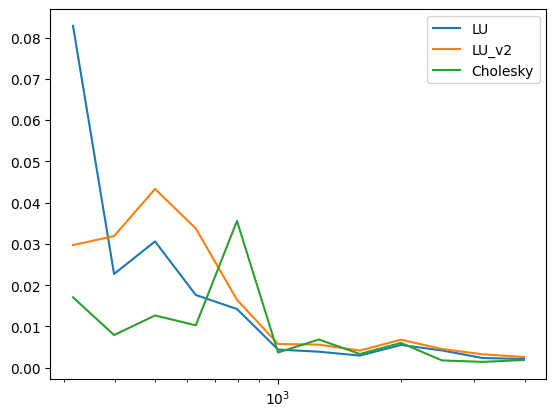

In [10]:
ref = 1e-8*nList**3
plt.semilogx( nList, timeLU/ref, label='LU')
plt.semilogx( nList, timeLU_v2/ref, label='LU_v2')
plt.semilogx( nList, timeChol/ref, label='Cholesky')

plt.legend()
plt.show()

## Some timings (GPU)

In [11]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is ', device)

Device is  cpu


In [12]:
n = int(1e4)
A = torch.randn(n,n)
b_gpu = torch.randn(n,1,device=device)
A_np  = A.numpy()
A_gpu = torch.randn(n,n,device=device)

In [13]:
# Run it on the CPU using the torch library
%time P, L, U = torch.linalg.lu(A, pivot=True)

A_np_copy = A_np.copy()
# Still on the CPU but using the scipy library
%time p, L, U = sla.lu(A_np, permute_l=False, p_indices=True)
%time p, L, U = sla.lu(A_np_copy, permute_l=False, p_indices=True, overwrite_a=True)
%time PL, U = sla.lu(A_np, permute_l=True)

CPU times: user 12.1 s, sys: 1.12 s, total: 13.2 s
Wall time: 15 s
CPU times: user 18 s, sys: 480 ms, total: 18.4 s
Wall time: 14.9 s
CPU times: user 18.6 s, sys: 351 ms, total: 19 s
Wall time: 11.4 s
CPU times: user 18.7 s, sys: 672 ms, total: 19.4 s
Wall time: 12.9 s


In [14]:
# Now run it on the GPU
# Proper way to time it is with synchronization
if torch.cuda.is_available():
    tic = time.perf_counter()
    P, L, U = torch.linalg.lu(A_gpu, pivot=True)
    torch.cuda.synchronize()
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.5f} seconds (pivoting)")

    tic = time.perf_counter()
    P, L, U = torch.linalg.lu(A_gpu, pivot=False)
    torch.cuda.synchronize()
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.5f} seconds")

    tic = time.perf_counter()
    LU, pivots = torch.linalg.lu_factor(A_gpu, pivot=True)
    torch.cuda.synchronize()
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.5f} seconds (pivoting)")

    tic = time.perf_counter()
    LU, pivots = torch.linalg.lu_factor(A_gpu, pivot=False)
    torch.cuda.synchronize()
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.5f} seconds")

In [ ]:
# Let's now combine the LU with the back substitution
if torch.cuda.is_available():
    tic = time.perf_counter()
    LU, pivots = torch.linalg.lu_factor(A_gpu, pivot=False)
    x_gpu = torch.linalg.lu_solve( LU, pivots, b_gpu)
    torch.cuda.synchronize()
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.5f} seconds (no pivoting)")

In [ ]:
# Or just call their full package
# (this will do pivoting for increased accuracy)
if torch.cuda.is_available():
    tic = time.perf_counter()
    x_gpu = torch.linalg.solve( A_gpu, x_gpu)
    torch.cuda.synchronize()
    toc = time.perf_counter()
    print(f"Elapsed time: {toc - tic:0.5f} seconds (pivoting)")